### Organize PDF Files into a Dedicated Folder

In [1]:
import os
import shutil

target_folder = "Scanned_PDF_sources"
os.makedirs(target_folder, exist_ok=True)

# Moving all PDF files into the folder
for file in os.listdir():
    if file.lower().endswith(".pdf"):
        shutil.move(file, os.path.join(target_folder, file))

print(f" All PDF files moved to '{target_folder}'")

 All PDF files moved to 'Scanned_PDF_sources'


### Extract Contents of a ZIP File to Current Directory

In [2]:
import zipfile
import os

# Path to the zip file
zip_path = "Transcripts.zip"

# Destination folder where files will be extracted
extract_to = os.getcwd()

# Unzip the folder
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Extracted to: {extract_to}")

Extracted to: d:\test_1


### Convert First Three Pages of Each PDF to Images 

In [3]:
import os
import fitz  

# Defining input and output directories
input_folder = "Scanned_PDF_sources"
output_base_folder = "overall_folder"

# Creating output base folder if it doesn't exist
os.makedirs(output_base_folder, exist_ok=True)

def pdf_to_images(pdf_path, output_folder):
    pdf_name = os.path.splitext(os.path.basename(pdf_path))[0]
    pdf_output_folder = os.path.join(output_folder, pdf_name)
    os.makedirs(pdf_output_folder, exist_ok=True)

    doc = fitz.open(pdf_path)

    for i, page in enumerate(doc, start=1):
        if i <= 3:  # Saving only the first 3 pages
            pix = page.get_pixmap()
            image_path = os.path.join(pdf_output_folder, f"{pdf_name}_page_{i}.png")
            pix.save(image_path)

    print(f"Images saved in folder: {pdf_output_folder}")

# Processing all PDF files in the input folder
for filename in os.listdir(input_folder):
    if filename.lower().endswith(".pdf"):
        full_pdf_path = os.path.join(input_folder, filename)
        pdf_to_images(full_pdf_path, output_base_folder)

Images saved in folder: overall_folder\Buendia - Instruccion
Images saved in folder: overall_folder\Constituciones sinodales Calahorra 1602
Images saved in folder: overall_folder\Ezcaray - Vozes
Images saved in folder: overall_folder\Mendo - Principe perfecto
Images saved in folder: overall_folder\Paredes - Reglas generales


### Extract and Save Words and Coordinates from OCR with Margin-Based Filtering and Visualization

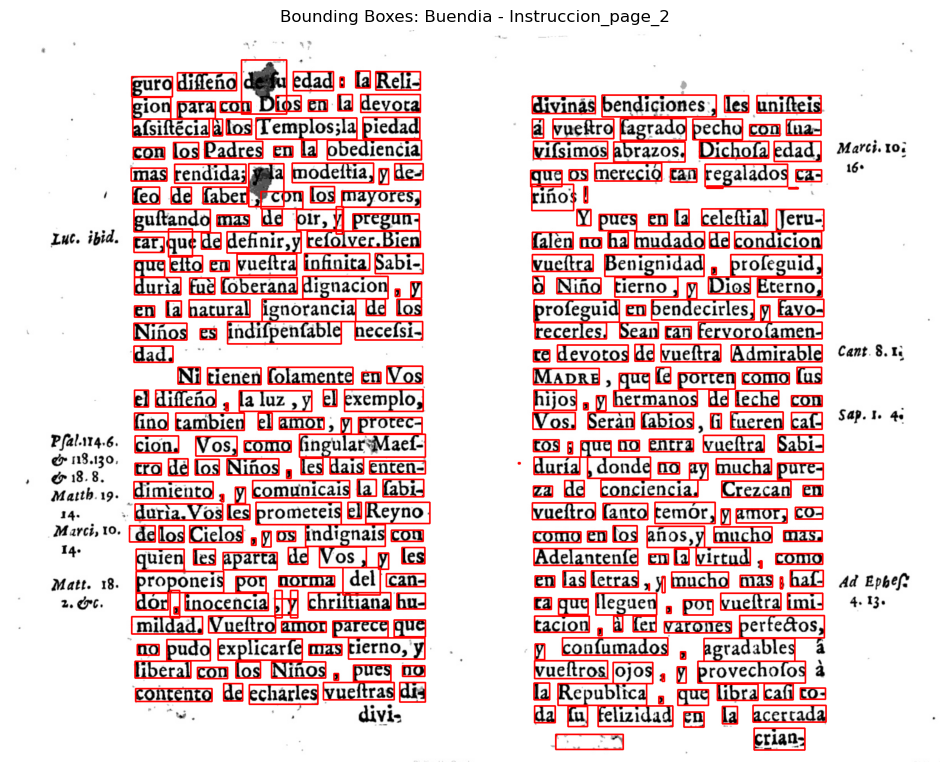

Processed image -> Coordinates: Coordinates/Buendia - Instruccion_page_2_coord.txt, Words: Words/Buendia - Instruccion_page_2_words.txt


In [4]:
import cv2
import pytesseract
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Input image path
image_path = "overall_folder\Buendia - Instruccion\Buendia - Instruccion_page_2.png" # Please adjust for testing for different documents

# Output directories
coordinates_dir = "Coordinates"
words_dir = "Words"
os.makedirs(coordinates_dir, exist_ok=True)
os.makedirs(words_dir, exist_ok=True)

# Extract base name
base_name = os.path.splitext(os.path.basename(image_path))[0] 

# Load and prepare image
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pil_image = Image.fromarray(image_rgb)

# OCR with bounding box data
custom_config = r'--oem 3 --psm 3'
data = pytesseract.image_to_data(pil_image, config=custom_config, output_type=pytesseract.Output.DICT)

# Converting to DataFrame
df = pd.DataFrame({
    "x1": data["left"],
    "y1": data["top"],
    "width": data["width"],
    "height": data["height"],
    "word": data["text"]
})

# Filtering out empty text
df = df[df["word"].str.strip() != ""]

# Computing bounding box (x2, y2)
df["x2"] = df["x1"] + df["width"]
df["y2"] = df["y1"] + df["height"]

# Margin metrics
df["left_margin_metric"] = df["y1"] + df["x1"]
df["right_margin_metric"] = df["x2"] + df["y2"]

bbox_largest_left_metric = df.loc[df["left_margin_metric"].idxmin()]
bbox_largest_right_metric = df.loc[df["right_margin_metric"].idxmax()]
left_margin = bbox_largest_left_metric["x1"]
right_margin = bbox_largest_right_metric["x2"]

# Filtering within margins
df["within_margins"] = (df["x2"] >= left_margin) & (df["x1"] <= right_margin)
filtered_df = df[df["within_margins"]]

# Saving coordinates
coordinates_file = f"Coordinates/{base_name}_coord.txt"
with open(coordinates_file, "w") as f:
    for _, row in filtered_df.iterrows():
        f.write(f"{row['x1']},{row['y1']},{row['x2']},{row['y2']}\n")

# Saving words
words_file = f"Words/{base_name}_words.txt"
with open(words_file, "w") as f:
    for _, row in filtered_df.iterrows():
        f.write(f"{row['word']}\n")

# Drawing bounding boxes
for _, row in filtered_df.iterrows():
    cv2.rectangle(image_rgb, (row["x1"], row["y1"]), (row["x2"], row["y2"]), (255, 0, 0), 2)

# Showing image with bounding boxes
plt.figure(figsize=(12, 12))
plt.imshow(image_rgb)
plt.title(f"Bounding Boxes: {base_name}")
plt.axis("off")
plt.show()

print(f"Processed image -> Coordinates: {coordinates_file}, Words: {words_file}")

### Convert DOCX Transcripts to Word-Level TXT Files

In [5]:
import re
import os
from docx import Document

# Folder containing the .docx files
docx_folder = "Transcripts"  

# Output folder for transcripts
transcripts_folder = "Transcript to txt"
os.makedirs(transcripts_folder, exist_ok=True)

# Process each .docx file in the folder
for file_name in os.listdir(docx_folder):
    if file_name.endswith(".docx"):  # Ensure it's a .docx file
        docx_path = os.path.join(docx_folder, file_name)
        doc = Document(docx_path)

        # Extract base name of the document (without extension)
        docx_name = os.path.splitext(file_name)[0]

        # Initialize variables
        page_content = {}
        current_page = None

        # Reading document and segregate by "PDF pX" headings
        for para in doc.paragraphs:
            text = para.text.strip()

            # Detecting headers like "PDF p1", "PDF p2", etc.
            if re.match(r"^PDF p\d+", text):
                current_page = text  # Example: "PDF p1"
                page_content[current_page] = []
            elif current_page:  # Store content under the detected page header
                page_content[current_page].append(text)

        # Processing each page and save to corresponding .txt file
        for page, content in page_content.items():
            # Extract the page number from "PDF pX"
            page_number = re.search(r"\d+", page).group()

            # Generating output file name
            output_file = os.path.join(transcripts_folder, f"{docx_name}_page_{page_number}_transcript.txt")

            # Flattening content into a single string
            full_text = " ".join(content)

            # Splitting into words (treating punctuation as separate words)
            words = re.findall(r"[\w]+|[^\w\s]", full_text)

            # Saving to file (one word per line)
            with open(output_file, "w", encoding="utf-8") as f:
                previous_word = None  # To store the last word

                for word in words:
                    if word == "-":
                        if previous_word is not None:
                            # Append '-' to the previous word instead of adding a new line
                            previous_word += "-"
                    elif word == ",":
                        if previous_word is not None:
                            # Append '-' to the previous word instead of adding a new line
                            previous_word += ","
                        
                    else:
                        if previous_word is not None:
                            f.write(previous_word + "\n")  # Write the previous word
                        previous_word = word  # Update previous word

                # Write the last word if it exists
                if previous_word is not None:
                    f.write(previous_word + "\n")

            print(f"Saved: {output_file}")

print("Processing complete! Transcripts saved in the 'Transcripts' folder.")


Saved: Transcript to txt\Buendia transcription_page_1_transcript.txt
Saved: Transcript to txt\Buendia transcription_page_2_transcript.txt
Saved: Transcript to txt\Buendia transcription_page_3_transcript.txt
Saved: Transcript to txt\Constituciones sinodales transcription_page_1_transcript.txt
Saved: Transcript to txt\Constituciones sinodales transcription_page_2_transcript.txt
Saved: Transcript to txt\Constituciones sinodales transcription_page_3_transcript.txt
Saved: Transcript to txt\Ezcaray transcription_page_1_transcript.txt
Saved: Transcript to txt\Ezcaray transcription_page_2_transcript.txt
Saved: Transcript to txt\Ezcaray transcription_page_3_transcript.txt
Saved: Transcript to txt\Mendo transcription_page_1_transcript.txt
Saved: Transcript to txt\Mendo transcription_page_2_transcript.txt
Saved: Transcript to txt\Mendo transcription_page_3_transcript.txt
Saved: Transcript to txt\Mendo transcription_page_4_transcript.txt
Saved: Transcript to txt\Mendo transcription_page_5_transcri

### Crop Word Images Using Bounding Boxes and Correct Filenames via Levenshtein Matching with Transcript

In [6]:
import cv2
import os

# Load the image
image_path = "overall_folder\Buendia - Instruccion\Buendia - Instruccion_page_2.png" # Update according to the required document
image = cv2.imread(image_path)

# Extract base name for saving
image_name = os.path.splitext(os.path.basename(image_path))[0]

# Directory to save cropped word images
output_dir = f"{image_name}_cropped_words"
os.makedirs(output_dir, exist_ok=True)

# Read coordinates from the file
coordinates_file = f"Coordinates\{image_name}_coord.txt"
with open(coordinates_file, "r") as f:
    lines = f.readlines()

# Read words from the text file
words_file = f"Words\{image_name}_words.txt"
with open(words_file, "r", encoding="utf-8") as f:
    words = [line.strip() for line in f.readlines() if line.strip()]  # Remove empty lines

# Ensure we have the same number of words and coordinates
if len(words) != len(lines):
    print(f"Warning: Mismatch in the number of words ({len(words)}) and coordinates ({len(lines)}).")

# Iterate through coordinates and crop images
for idx, line in enumerate(lines):
    x1, y1, x2, y2 = map(int, line.strip().split(","))
    
    # Crop the word from the image
    cropped_word = image[y1:y2, x1:x2]

    # Get the corresponding word from the list
    word_name = words[idx] if idx < len(words) else f"word_{idx+1}"
    #sanitized_word_name = "".join(c for c in word_name if c.isalnum() or c in (' ', '_'))  # Clean filename

    # Save the cropped image
    cropped_image_path = os.path.join(output_dir, f"{word_name}.png")
    cv2.imwrite(cropped_image_path, cropped_word)
    print(f"Saved cropped word '{word_name}' at {cropped_image_path}")

print("Cropping complete. All word images are saved in the 'cropped_words_pg_1' directory.")



##############################################################################################################



# Performing corection of image_name

import os
import shutil
import Levenshtein

# Paths
transcript_file = "Transcript to txt\Buendia transcription_page_2_transcript.txt"
input_folder = f"{image_name}_cropped_words"

input_folder_name = os.path.splitext(os.path.basename(input_folder))[0]

output_folder = f"{input_folder_name}_corrected"

# Ensure the output directory exists
os.makedirs(output_folder, exist_ok=True)

# Function to load words from the transcript (preserving case)
def load_transcript_words(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        words = set(f.read().split())  # Extract unique words while preserving case
    return words

# Function to find the most similar word while keeping capitalization
def find_best_match(word, word_list):
    best_match = None
    best_score = float("inf")

    for transcript_word in word_list:
        score = Levenshtein.distance(word.lower(), transcript_word.lower())  # Compute Levenshtein distance
        if score < best_score:
            best_score = score
            best_match = transcript_word  # Preserve original capitalization

    return best_match if best_score <= len(word) * 0.4 else None  # Only accept if similarity is above 60%

# Load words from transcript (preserving case)
transcript_words = load_transcript_words(transcript_file)

# Keep track of used names to remove duplicates
used_filenames = set()

# Process each image in the input folder
for image_file in os.listdir(input_folder):
    input_image_path = os.path.join(input_folder, image_file)

    # Extract the base name (removing extension)
    image_name, ext = os.path.splitext(image_file)

    # Find the best match while keeping capitalization
    best_match = find_best_match(image_name, transcript_words)

    if best_match:
        new_filename = f"{best_match}.png"  # Keep capitalization
        output_image_path = os.path.join(output_folder, new_filename)

        # If this word is already assigned, do not save a duplicate
        if best_match in used_filenames:
            print(f"Skipped duplicate: {image_file} (Already assigned to {new_filename})")
        else:
            # Copy the image to the new folder with the corrected name
            shutil.copy(input_image_path, output_image_path)
            used_filenames.add(best_match)
            print(f"Saved: {image_file} -> {output_image_path}")
    else:
        print(f"Skipped: {image_file} (No suitable match found)")

print("Processing complete! All corrected images are saved in 'cropped_words_pg_1_corrected'.")


Saved cropped word 'guro' at Buendia - Instruccion_page_2_cropped_words\guro.png
Saved cropped word 'diffeiio' at Buendia - Instruccion_page_2_cropped_words\diffeiio.png
Saved cropped word 'ag' at Buendia - Instruccion_page_2_cropped_words\ag.png
Saved cropped word 'edad' at Buendia - Instruccion_page_2_cropped_words\edad.png
Saved cropped word ':' at Buendia - Instruccion_page_2_cropped_words\:.png
Saved cropped word 'Ia' at Buendia - Instruccion_page_2_cropped_words\Ia.png
Saved cropped word 'Reli-' at Buendia - Instruccion_page_2_cropped_words\Reli-.png
Saved cropped word 'gion' at Buendia - Instruccion_page_2_cropped_words\gion.png
Saved cropped word 'para' at Buendia - Instruccion_page_2_cropped_words\para.png
Saved cropped word 'con' at Buendia - Instruccion_page_2_cropped_words\con.png
Saved cropped word 'Dios' at Buendia - Instruccion_page_2_cropped_words\Dios.png
Saved cropped word 'en' at Buendia - Instruccion_page_2_cropped_words\en.png
Saved cropped word 'la' at Buendia - I

### Evaluate OCR Accuracy on Cropped Word Images Against Transcript Ground Truth

In [7]:
import os
import cv2
import pytesseract
import string

# Paths
word_images_dir = output_dir  # Directory with cropped word images
ground_truth_file = transcript_file  # Use the transcript file for ground truth

# Function to normalize words (lowercase, remove punctuation)
def normalize(word):
    return word.strip().translate(str.maketrans('', '', string.punctuation)).lower()

# Loading and filtering ground truth words
ground_truth_words = []
with open(ground_truth_file, "r", encoding="utf-8") as f:
    for line in f:
        normalized = normalize(line)
        if normalized and any(c.isalnum() for c in normalized):  # Skip lines with only punctuation
            ground_truth_words.append(normalized)

ground_truth_set = set(ground_truth_words)

# Loading all .png images
image_files = sorted([f for f in os.listdir(word_images_dir) if f.lower().endswith(".png")])

predicted_words = []
matched_words = []

# OCR and evaluation loop
for image_file in image_files:
    img_path = os.path.join(word_images_dir, image_file)
    img = cv2.imread(img_path)

    if img is None:
        print(f"⚠️ Could not read image: {image_file}. Skipping...")
        continue

    # Preprocessing
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # OCR
    config = "--psm 7"
    ocr_text = pytesseract.image_to_string(thresh, config=config).strip()
    norm_pred = normalize(ocr_text)

    if norm_pred:
        predicted_words.append(norm_pred)
        if norm_pred in ground_truth_set:
            matched_words.append(norm_pred)

# Evaluation
total_predicted = len(predicted_words)
total_matched = len(matched_words)
accuracy = total_matched / total_predicted if total_predicted > 0 else 0

# Results
print(f"Total word images processed: {len(image_files)}")
print(f"Valid OCR predictions made : {total_predicted}")
print(f"Predicted words matched in transcript: {total_matched}")
print(f"Matching Accuracy: {accuracy * 100:.2f}%")


⚠️ Could not read image: afsiftÃ©cia.png. Skipping...
⚠️ Could not read image: delâ€™.png. Skipping...
⚠️ Could not read image: dÃ©.png. Skipping...
⚠️ Could not read image: falÃ©n.png. Skipping...
⚠️ Could not read image: perfeÃ©os,.png. Skipping...
⚠️ Could not read image: Â»y.png. Skipping...
⚠️ Could not read image: â€˜de.png. Skipping...
⚠️ Could not read image: â€˜mas.png. Skipping...
⚠️ Could not read image: â€˜mildad..png. Skipping...
⚠️ Could not read image: â€™.png. Skipping...
Total word images processed: 209
Valid OCR predictions made : 193
Predicted words matched in transcript: 101
Matching Accuracy: 52.33%
